In [ ]:
# !pip install qiskit --quiet
# !pip install qiskit-machine-learning --quiet
# !pip install pylatexenc --quiet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit, prange

import torch
from torch import Tensor, LongTensor
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Module, Linear
from torchvision import datasets, transforms
import torch.nn.functional as F

from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from qiskit import QuantumCircuit, Aer, transpile
from qiskit_machine_learning.neural_networks import CircuitQNN,TwoLayerQNN
from qiskit.opflow import AerPauliExpectation
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit import ParameterVector
from qiskit.utils import QuantumInstance

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [3]:
device = get_default_device()
device

device(type='cpu')

In [4]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [5]:
def entangling_circuit(bits):
    qc = QuantumCircuit(bits)
    bits = list(range(bits))
    for this_bit, next_bit in zip(bits, bits[1:]):
        qc.cz(this_bit, next_bit)
    if(len(bits)!= 2):
        qc.cz(bits[0], bits[-1])
    return qc

In [6]:
# cluster state
def cluster_state_circuit(bits):
    qc = QuantumCircuit(bits)
    qc.h(list(range(bits)))
    qc.compose(entangling_circuit(bits), inplace=True)
    return qc

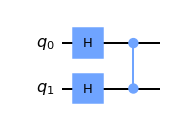

In [7]:
circuit = cluster_state_circuit(2)
circuit.draw('mpl')

In [8]:
def one_qubit_unitary(thetas):
    qc = QuantumCircuit(1)
    qc.rx(thetas[0], 0)
    qc.ry(thetas[1], 0)
    qc.rz(thetas[2], 0)
    return qc

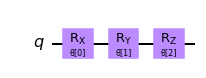

In [9]:
thetas = ParameterVector('θ', length=3)
circuit = one_qubit_unitary(thetas)
circuit.draw('mpl')

In [10]:
def two_qubit_pool(thetas):
    qc = QuantumCircuit(2)
    qc = qc.compose(one_qubit_unitary(thetas[0:3]), [1])
    qc = qc.compose(one_qubit_unitary(thetas[3:6]), [0])
    qc.cnot(0,1)
    qc = qc.compose(one_qubit_unitary(thetas[0:3]).inverse(), [1])
    return qc

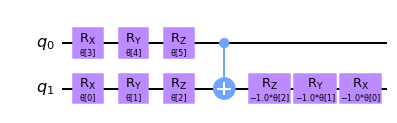

In [11]:
thetas = ParameterVector('θ', length=6)
circuit = two_qubit_pool(thetas)
circuit.draw('mpl')

In [ ]:
def quantum_conv_circuit(bits, thetas):
    qc = QuantumCircuit(bits)
    qc.compose(entangling_circuit(bits), inplace=True)
    for i in range(bits):
        qc.compose(one_qubit_unitary(thetas[i:i+3]), [i], inplace=True)
    return qc